# 0.6_ss_chap06_gradients
- gradient の実行結果を動かしてから、中身について見てみる

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from src import utils
import itertools
import logging
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
from collections import OrderedDict
%matplotlib inline

In [4]:
from src.common.optimizer import SGD, Momentum, Nesterov, AdaGrad
from src.common.optimizer import RMSprop, Adam
from src.ch06.optimizer_compare_naive import main

from src.common.gradient import numerical_gradient
from src.common.gradient import numerical_gradient_on_array

In [5]:
log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(level=logging.INFO, format=log_fmt)
# logging.basicConfig(level=logging.DEBUG, format=log_fmt)
logger = logging.getLogger()

## from optimier_compare_naive

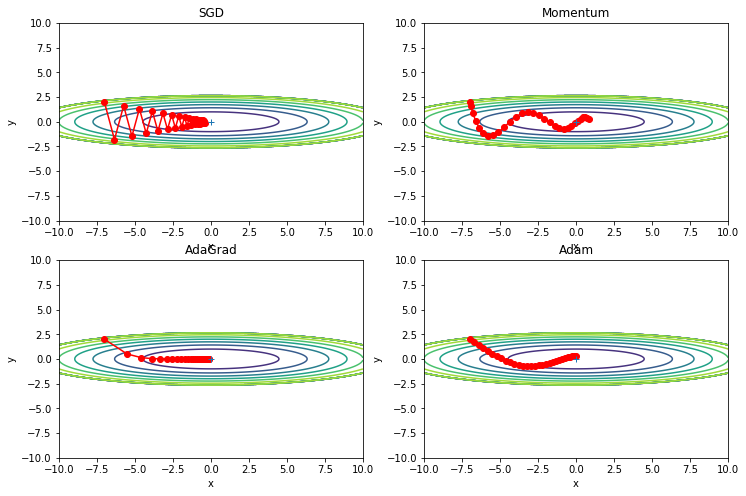

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
main()

## Write it!

In [7]:
def f(x, y):
        return x**2 / 20.0 + y**2


def df(x, y):
        return x / 10.0, 2.0*y


In [8]:
def bowl(x):
        ''' f(x,y) = 1/20 * x[0]^2 + x[1]^2
        ベクトルで入ってきた場合と、2次元（マトリックス）で入ってき場合に対応する
        -> どんな形でも、結局これだけで対応できちゃう

        Parameters
        ----------
        x: np.ndarray
        x values
        y: np.ndarray
        y values

        Returns
        -------
        f(x,y) = 1/20 * x^2 + y^2
        '''
        # takes numpy as input
        if type(x) != np.ndarray:
                raise ValueError("Only takes numpy.array as input")

        return 1/20*x[0]**2 + x[1]**2

In [9]:
class SGD:
        ''' Simple class for SGD
        '''
        def __init__(self, lr = 0.01):
                '''
                '''
                self.lr = lr
        
        def update(self, params, grads):
                ''' Update according to gradient
                '''
                for key in params.keys():
                        params[key] -= self.lr * grads[key]

In [10]:
init_pos = np.array([-7., 2.])

In [11]:
params = {'x': init_pos[0], 'y': init_pos[1]}
grads = {'x': 0, 'y': 0}


In [12]:
idx = 1

In [13]:
optimizer = SGD(lr = 0.95)

In [14]:
x_history = []
y_history = []

params = {'x': init_pos[0], 'y': init_pos[1]}

In [15]:
for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        logger.debug(f"params: {params}")
        grads['x'], grads['y'] = df(params['x'], params['y'])

        logger.debug(f"grads: {grads}")
        optimizer.update(params, grads)

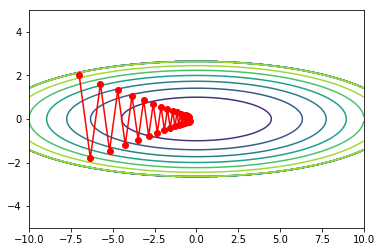

In [16]:
x = np.arange(-10, 10, 0.01)
y = np.arange(-5, 5, 0.01)

X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# for simple contour line
mask = Z > 7
Z[mask] = 0

plt.contour(X, Y, Z)

plt.plot(x_history, y_history, 'o-', color="red")

### ちゃんと gradient 計算しよう

In [17]:
grad = numerical_gradient(bowl, init_pos)

In [18]:
x = np.array([params['x'], params['y']])
x

array([-0.350393  ,  0.08478232])

In [19]:
grads = {}
grads['x'] = grad[0]
grads['y'] = grad[1]

In [20]:
def update_grads(f, optimizer, 
                 init_pos=np.array([-7., 2.]), n_reps=30):
        ''' Update gradient
        
        Parameters
        ----------
        f: function
                function to update
        optimzer: optimizer
                rule to update
        init_pos: np.array
                initial postion
        n_reps: int
                number of reps to repeat
                
        Returns
        -------
        x_history: list
                history of x
        y_history: list
                history of y
        '''
        grads = {}
        x_history = []
        y_history = []

        params = {'x': init_pos[0], 'y': init_pos[1]}

        for i in range(n_reps):
                x_history.append(params['x'])
                y_history.append(params['y'])

                logger.debug(f"params: {params}")
                params_array = np.array([params['x'], params['y']])
                grad = numerical_gradient(f, params_array)
                grads['x'] = grad[0]
                grads['y'] = grad[1]

                logger.debug(f"grads: {grads}")
                optimizer.update(params, grads)
        
        return x_history, y_history

In [21]:
def plot_history(x_history, y_history):
        ''' Function to plot results
        '''
        x = np.arange(-10, 10, 0.01)
        y = np.arange(-5, 5, 0.01)

        X, Y = np.meshgrid(x, y)
        Z = f(X, Y)

        # for simple contour line
        mask = Z > 7
        Z[mask] = 0

        plt.contour(X, Y, Z)

        plt.plot(x_history, y_history, 'o-', color="red")

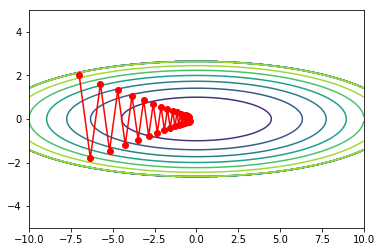

In [22]:
plot_history(*update_grads(bowl, SGD(lr=0.95)))

## Momentum

In [28]:
class Momentum:
        ''' Momentum SGD
        '''
        def __init__(self, lr=0.01, momentum=0.9):
                '''
                Parameters
                ----------
                lr: float
                        learning rate
                momentum: float
                        ratio to which the momentum presists
                v: float
                        velocity
                '''
                self.lr = lr
                self.momentum = momentum
                self.v = None
        
        def update(self, params, grads):
                if self.v is None:
                        self.v = {}
                        for key, val in params.items():
                                self.v[key] = np.zeros_like(val)
                
                for key in params.keys():
                        self.v[key] = \
                            self.momentum*self.v[key]-self.lr*grads[key]
                        params[key] += self.v[key]
        

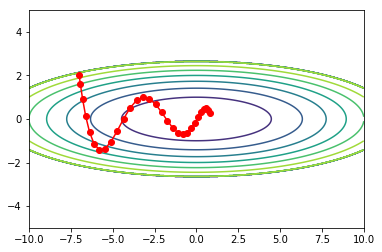

In [30]:
plot_history(*update_grads(bowl, Momentum(lr=0.1)))

### AdaGrad

In [31]:
class AdaGrad:
        ''' AdaGrad
        '''
        def __init__(self, lr=0.01):
                '''
                Parameters
                ----------
                lr: float
                        learning rate
                h: float
                        something like velocity
                '''
                self.lr = lr
                self.h = None
        
        def update(self, params, grads):
                # h is initialized as the same shape as params
                if self.h is None:
                        self.h = {}
                        for key, val in params.items():
                                self.h[key] = np.zeros_like(val)
                
                for key in params.keys():
                        # h is updated as the sqaure of gradient
                        # this will continue to get larger
                        self.h[key] += grads[key] * grads[key]
                        # the keys will be updated, with a penalty of h
                        # this means the update 
                        # will get continously smaller
                        params[key] -= self.lr *\
                                grads[key] / (np.sqrt(self.h[key]) + 1e-7)
                                

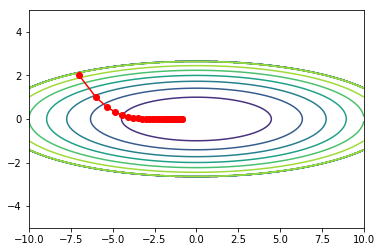

In [42]:
plot_history(*update_grads(bowl, AdaGrad(lr=1.), n_reps=30))

### Adam

In [44]:
class Adam:
        """Adam (http://arxiv.org/abs/1412.6980v8)"""
        def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
                self.lr = lr
                self.beta1 = beta1
                self.beta2 = beta2
                self.iter = 0
                self.m = None
                self.v = None
                
        def update(self, params, grads):
                # m and v are ititialized as same shape of params
                if self.m is None:
                        self.m, self.v = {}, {}
                        for key, val in params.items():
                                self.m[key] = np.zeros_like(val)
                                self.v[key] = np.zeros_like(val)
                
                self.iter += 1
                # 0.999**iter will get smaller slowly
                # so np.sqrt() will go from 1 --> 0 slowly
                # 0.9**self.iter will go to 0 quite quicky
                # so it's a regularzation that's quite diffuclt
                lr_t = self.lr * np.sqrt(1. - self.beta2**self.iter) /\
                    (1. - self.beta1**self.iter)
                
                for key in params.keys():
                        self.m[key] += (1-self.beta1) *\
                                (grads[key] - self.m[key])
                        self.v[key] += (1-self.beta2) *\
                                (grads[key]**2 - self.v[key])
                        
                        params[key] -= lr_t *\
                                self.m[key] / (np.sqrt(self.v[key])) + 1e-7

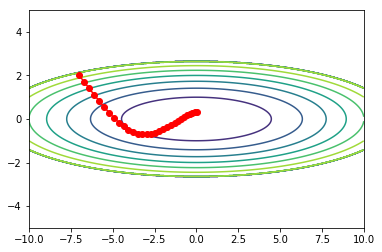

In [60]:
plot_history(*update_grads(bowl, Adam(lr=.3), n_reps=30))

### NEstereov

In [49]:
class Nesterov:
        """ Nesterov's Accelerated Gradient 
        (http://arxiv.org/abs/1212.0901)
        """
        def __init__(self, lr=0.01, momentum=.9):
                self.lr = lr
                self.momentum=momentum
                self.v = None
        
        def update(self, params, grads):
                if self.v is None:
                        self.v = {}
                        for key, val in params.items():
                                self.v[key] = np.zeros_like(val)
                
                for key in params.keys():
                        self.v[key] *= self.momentum
                        self.v[key] -= self.lr * grads[key]
                        params[key] += self.v[key] * self.momentum**2 
                        params[key] -= (1+self.momentum) * self.lr * grads[key]
        
        

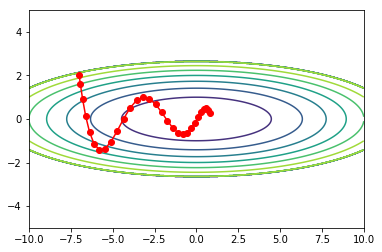

In [56]:
plot_history(*update_grads(bowl, Momentum(lr=.1)))

### RMSprop

In [63]:
class RMSprop:
        ''' RMSprop
        '''
        
        def __init__(self, lr=0.01, decay_rate=.99):
                self.lr = lr
                self.decay_rate = decay_rate
                self.h = None
                
        def update(self, params, grads):
                if self.h is None:
                        self.h = {}
                        for key, val in params.items():
                                self.h[key] = np.zeros_like(val)
                                
                
                for key in params.keys():
                        self.h[key] *= self.decay_rate
                        self.h[key] += (1 - self.decay_rate) *\
                            grads[key] ** 2 
                        params[key] -= self.lr * \
                            grads[key] / (np.sqrt(self.h[key]) + 1e-7)

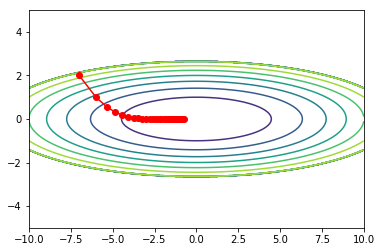

In [65]:
plot_history(*update_grads(bowl, RMSprop(lr=.1)))